In [2]:
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp

from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt


## Obtaining grid

In [4]:
def generate_gp_data(l=30, train_size=20, test_size=10, noise_std=0.01, seed=None):
    """
    Generates training and test datasets for Gaussian Process regression using PyTorch.

    Args:
        l (int, optional): Total number of grid points. Defaults to 30.
        train_size (int, optional): Number of training points. Defaults to 20.
        test_size (int, optional): Number of test points. Defaults to 10.
        noise_std (float, optional): Standard deviation of Gaussian noise. Defaults to 0.01.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        tuple:
            - X_train (torch.Tensor): Training input points of shape (train_size,).
            - y_train (torch.Tensor): Training observations with noise of shape (train_size,).
            - X_test (torch.Tensor): Test input points of shape (test_size,).
            - y_test (torch.Tensor): Test observations with noise of shape (test_size,).
    """
    # Set random seed for reproducibility if provided
    if seed is not None:
        torch.manual_seed(seed)
    
    # Define the function g(x)
    def g(x):
        return -(torch.sin(6 * torch.pi * x)**2) + 6 * (x**2) - 5 * (x**4) + 1.5

    # Create a grid of points in [0, 1]
    xx = torch.linspace(0, 1, steps=l)
    
    # Shuffle the grid using a random permutation
    perm = torch.randperm(l)
    xx = xx[perm]
    
    # Split into training and test sets
    X_train = xx[:train_size]
    X_test = xx[train_size:train_size + test_size]
    
    # Generate noisy observations for training and testing
    y_train = g(X_train) + torch.normal(mean=0.0, std=noise_std, size=(train_size,))
    y_test = g(X_test) + torch.normal(mean=0.0, std=noise_std, size=(test_size,))
    
    return X_train, y_train, X_test, y_test


In [5]:
X, y, x_test, y_test = generate_gp_data()

In [6]:
    def g(x):
        return -(torch.sin(6 * torch.pi * x)**2) + 6 * (x**2) - 5 * (x**4) + 1.5

In [7]:
import matplotlib.pyplot as plt

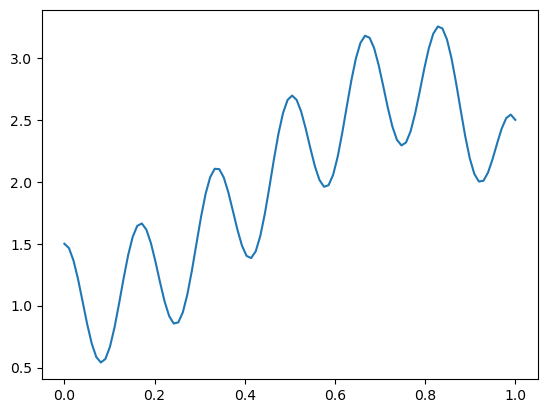

In [84]:
xx = torch.linspace(0,1, 100)

plt.plot(xx, g(xx))
#plt.savefig("Function")

In [10]:
def rbf_kernel(x1, x2, length_scale=1.0, var=1.0):
    # Ensure x1 and x2 are 2D
    x1 = x1.unsqueeze(1) if x1.ndimension() == 1 else x1
    x2 = x2.unsqueeze(1) if x2.ndimension() == 1 else x2
    sqdist = torch.cdist(x1, x2) ** 2
    return var * torch.exp(-0.5 * sqdist / length_scale**2)

In [11]:
def matern_kernel(x1, x2, length_scale=1.0, var = 1.0):

    x1 = x1.unsqueeze(1) if x1.ndimension() == 1 else x1
    x2 = x2.unsqueeze(1) if x2.ndimension() == 1 else x2
    first_term = var*(1+torch.sqrt(torch.tensor(3))*torch.abs(x1-x2)/length_scale)
    second_term = torch.exp(-torch.sqrt(torch.tensor(3))*torch.abs(x1-x2)/length_scale)

    return first_term * second_term 
    

In [12]:
def log_likelihood(y, X, kernel, lengthscale, variance,sigma_n=0.01):
    K = kernel(X, X, lengthscale, variance) + sigma_n**2 * torch.eye(X.shape[0])
    L = torch.linalg.inv(K)
    log_det = torch.log(torch.linalg.det(K))
    
    return -0.5 * (y @ L @ y) - 0.5*log_det - 0.5 * len(X) * torch.log(torch.sqrt(torch.tensor(2 * torch.pi)))

## Gaussian proccess 

In [14]:
def plot(X,y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(0, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(0, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(0, 1)

## MAP

In [16]:
pyro.clear_param_store()
kernel = gp.kernels.Matern52(
    input_dim=1, 
)
gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.01))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000 
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

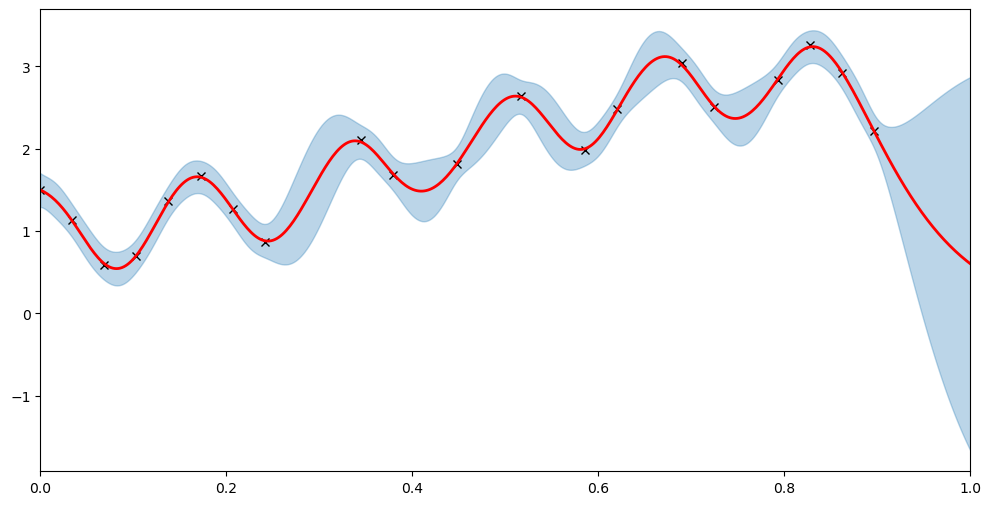

In [17]:
plot(X, y, model=gpr, plot_observed_data=True, plot_predictions=True)
#plt.savefig("matern_model")


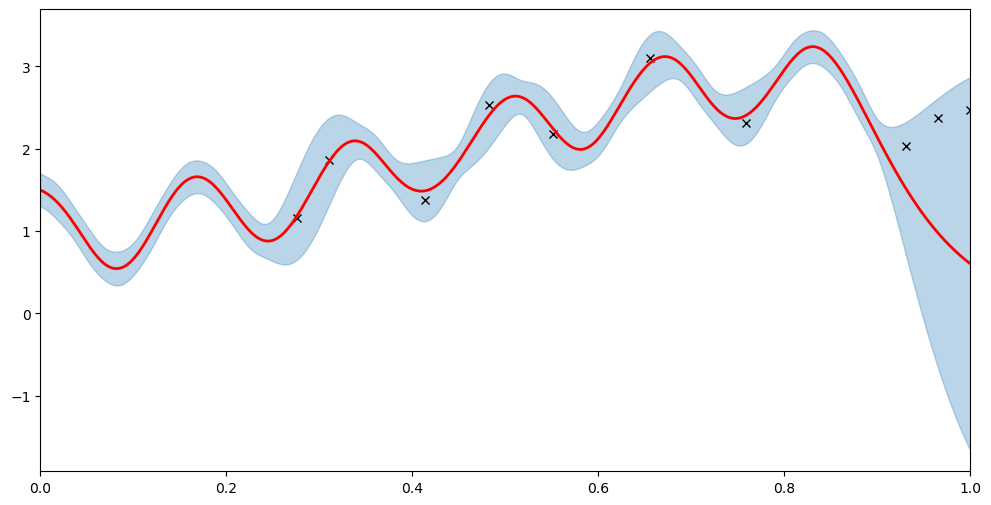

In [18]:
plot(x_test,y_test,model=gpr, plot_observed_data=True, plot_predictions=True)
#plt.savefig("matern_test_data")

In [90]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

Var_for_b2 = gpr.kernel.variance
len_for_b2 = gpr.kernel.lengthscale
noise_for_b2 = gpr.noise

variance = 3.6388773918151855
lengthscale = 0.18265767395496368
noise = 0.009999999776482582


In [20]:
def MAP(X, y, x_test,y_test,kernel2,  log_fun,noise =0.01):
    """
        Returns the loglikelihood based on MAP. Also return theta_star
    """
    pyro.clear_param_store()
    kernel = gp.kernels.Matern32(
        input_dim=1, 
    )
    gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.01))
    
    # Sampling from the priors.
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000 
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    gpr.set_mode("guide")
    var = gpr.kernel.variance
    lscale = gpr.kernel.lengthscale
    noise = gpr.noise

    logp = log_fun(y_test,x_test, kernel2, lscale, var)


    return logp, var, lscale, noise, 
    

## Nuts sampling

In [22]:
import arviz as az


In [23]:
pyro.clear_param_store()
def model(X, y):
    kernel = gp.kernels.Matern32(
        input_dim=1, 
    )
    gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.01))
    
    # note that our priors have support on the positive reals
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.model()

In [24]:
# Hyperparameters for sampling
num_samples = 1000      # total posterior samples
warmup_steps = 300      # "burn-in" period
num_chains = 2          # number of parallel MCMC chains

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)

mcmc.run(X, y)

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

/home/alex5848/anaconda3/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


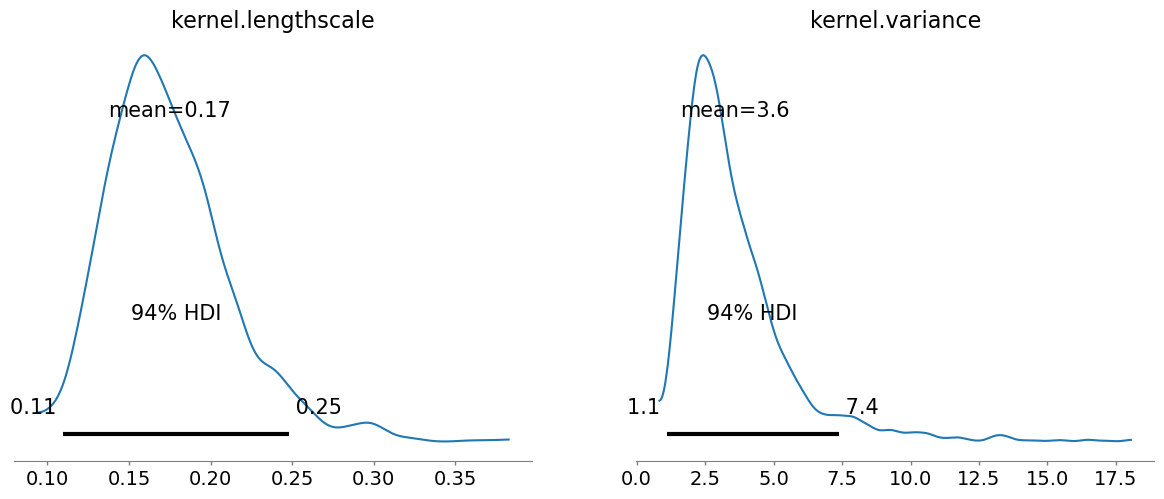

In [68]:
sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)

az.plot_posterior(sample_data)


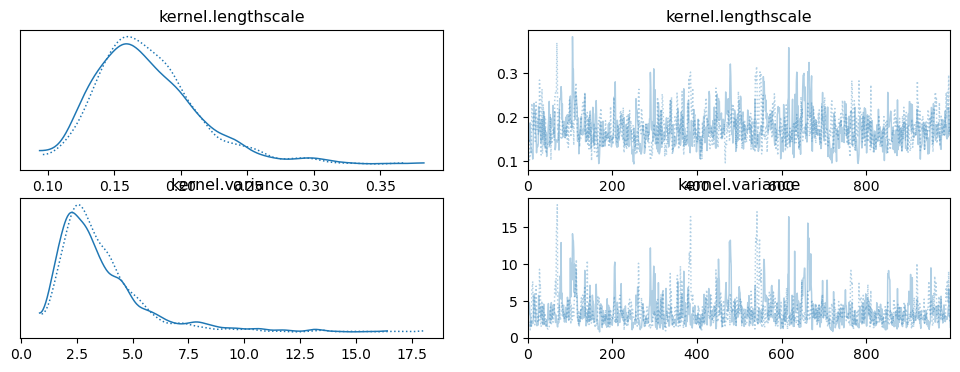

In [70]:
az.plot_trace(sample_data)


In [27]:
print(sample_summary)

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.175  0.039   0.110    0.248      0.002    0.001   
kernel.variance     3.588  2.063   1.092    7.379      0.100    0.072   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     452.0     484.0    1.0  
kernel.variance        538.0     522.0    1.0  


In [28]:
def NUTS_log(X, y, x_test, y_test, model, num_samples1, warmup_steps, num_chains, log_fun, kernel2):
    """
    Returns the mean(as a tensor) of 500 loglikelihoods
    computed with 500 different samples of the variance(alpha) and lengthscale
    
    """
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples1, warmup_steps=warmup_steps, num_chains=num_chains)

    mcmc.run(X, y)

    samples = mcmc.get_samples(num_samples = 500)
    log_list = []
    for i in range(500):
        log =  log_fun(y_test, x_test,kernel2, samples["kernel.lengthscale"][i],samples["kernel.variance"][i])
        log_list.append(log)
    values = torch.tensor(log_list) 

    return torch.mean(values)

In [74]:
def NUTS_log(X, y, x_test, y_test, model, num_samples1, warmup_steps, num_chains, log_fun, kernel2):
    """
    Returns the mean(as a tensor) of 500 loglikelihoods
    computed with 500 different samples of the variance(alpha) and lengthscale
    
    """
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples1, warmup_steps=warmup_steps, num_chains=num_chains)

    mcmc.run(X, y)

    samples = mcmc.get_samples(num_samples = 500)
    log_list = []
    for i in range(500):
        log =  log_fun(y_test, x_test,kernel2, samples["kernel.lengthscale"][i],samples["kernel.variance"][i])
        log_list.append(log)
    values = torch.tensor(log_list) 

    v = samples["kernel.variance"].mean()
    l = samples["kernel.lengthscale"].mean()

    return torch.mean(values), v, l 

In [ ]:
X,y, x_test, y_test = generate_gp_data()
nuts,v,l = NUTS_log(X, y,x_test,y_test, model, 1000, 300, 2, log_likelihood, rbf_kernel)

pyro.clear_param_store()
kernel = gp.kernels.Matern32(
        input_dim=1,variance = v, lengthscale= l 
    )
gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.01))

plot(X,y,plot_observed_data=True, plot_predictions=True, model = gpr, kernel = kernel)


In [ ]:
plot(X,y,plot_observed_data=True, plot_predictions=True, model = gpr, kernel = kernel)

## Running for 20 different datasets.

In [30]:
MAP_posteriors = []
NUTS_posteriors = []
x_test_list = []
y_test_list = []

for i in range(20):
    X,y, x_test, y_test = generate_gp_data()
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
    
    mao = MAP(X, y, x_test, y_test, rbf_kernel,  log_likelihood, noise = 0.01)
    MAP_posteriors.append(mao)
    
    nuts = NUTS_log(X, y,x_test,y_test, model, 1000, 300, 2, log_likelihood, rbf_kernel)
    NUTS_posteriors.append(nuts)

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/1300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1300 [00:00, ?it/s]

In [31]:
Nuts_mean_tensor = torch.tensor(NUTS_posteriors)

In [32]:
NUTS_posteriors

[tensor(-3988.7664),
 tensor(-3406.0935),
 tensor(-1129.0846),
 tensor(-350.5408),
 tensor(-5579.6641),
 tensor(-241.6290),
 tensor(-7448.9043),
 tensor(-4480.2866),
 tensor(-4067.2139),
 tensor(-1399.8276),
 tensor(-6650.7021),
 tensor(-3605.7065),
 tensor(-3567.0891),
 tensor(-4454.1050),
 tensor(-1197.1766),
 tensor(-2992.9980),
 tensor(-1086.9219),
 tensor(-2754.8660),
 tensor(-2101.3511),
 tensor(-1038.7400)]

In [33]:
MAP_mean = []
for tensors in MAP_posteriors:
    MAP_mean.append(tensors[0])
    

In [34]:
Map_mean_tensor = torch.tensor(MAP_mean)


In [72]:
print(f"Nuts_mean:{Nuts_mean_tensor.mean()}")
print(f"Nuts_std:{Nuts_mean_tensor.std()}")
print(f"MAP_mean:{Map_mean_tensor.mean()}")
print(f"MAP_std:{Map_mean_tensor.std()}")

Nuts_mean:-3077.08349609375
Nuts_std:2042.254638671875
MAP_mean:-2770.75927734375
MAP_std:2086.170166015625
